In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from setpoint_timeseries import generate_setpoint_timeseries

# Load data

### Setpoint timeseries

In [3]:
# Load the data
with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/setpoint_timeseries.pkl', 'rb') as f:
    full_setpoint_timeseries = pickle.load(f)

### Weather data

In [90]:
weather_data = pd.read_csv("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/G2500170_2018.csv")

# Change date time column name to timestamp
weather_data.rename(columns={'date_time': "timestamp"}, inplace=True)
weather_data.set_index('timestamp', inplace=True)
weather_data.index = pd.to_datetime(weather_data.index)

# Delete all columns except dry bulb temperature
weather_data = weather_data[["Dry Bulb Temperature [°C]"]]
weather_data.rename(columns={"Dry Bulb Temperature [°C]": "temperature"}, inplace=True)

# Create an entry for 2018-01-01 00:00:00
new_row = pd.DataFrame({'temperature': weather_data.iloc[0]['temperature']}, index=[pd.to_datetime('2018-01-01 00:00:00')])
weather_data = pd.concat([new_row, weather_data])

# Remove last 19 rows
weather_data = weather_data[:-24]

In [82]:
weather_data.head()

,temperature
2018-01-01 00:00:00,-17.2
2018-01-01 01:00:00,-17.2
2018-01-01 02:00:00,-17.8
2018-01-01 03:00:00,-18.9
2018-01-01 04:00:00,-18.9


### ResStock

In [51]:
resstock = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/MA_baseline_metadata_and_annual_results.parquet")

In [52]:
resstock["out.load.heating.energy_delivered.kbtu"]

bldg_id
10         63666.0
122        29495.0
129        42532.0
150        18312.0
183       114736.0
            ...   
549732     55953.0
549816     54300.0
549871     43077.0
549954     75445.0
549997    173817.0
Name: out.load.heating.energy_delivered.kbtu, Length: 11707, dtype: float64

### Building timeseries

In [ ]:
building_data = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/1000-0.parquet")

### Setpoint timeseries plot

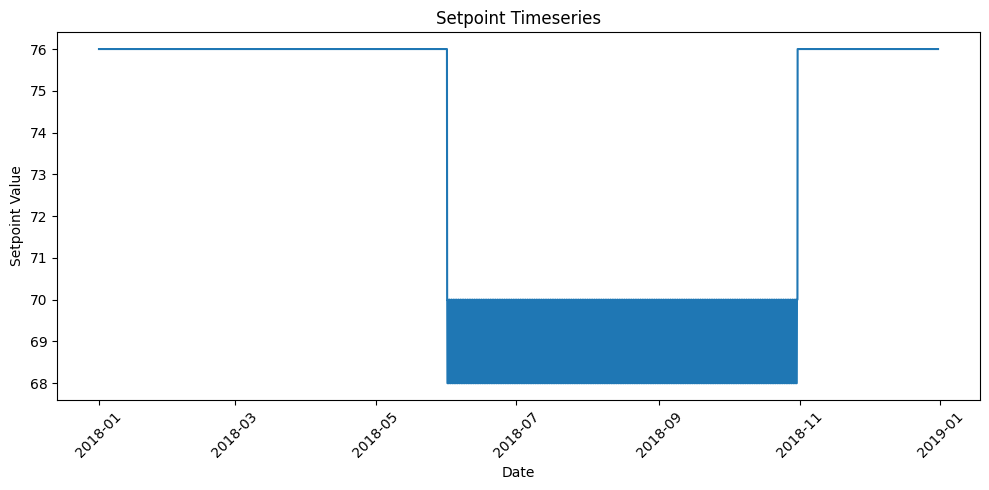

In [47]:
# Plot first timeseries
timeseries = full_setpoint_timeseries[1000]

# Plot the timeseries
plt.figure(figsize=(10, 5))
plt.plot(timeseries.index, timeseries["setpoint"])
plt.title("Setpoint Timeseries")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Timeseries prediction

In [91]:
# Predict timeseries with index 761
timeseries = full_setpoint_timeseries[1000]

train_size = 0.8
train = timeseries[:int(train_size * len(timeseries))]
test = timeseries[int(train_size * len(timeseries)):]

weather_train = weather_data[:int(train_size * len(weather_data))]
weather_test = weather_data[int(train_size * len(weather_data)):]

In [61]:
timeseries.head()

,setpoint
timestamp,
2018-01-01 00:00:00,76.0
2018-01-01 01:00:00,76.0
2018-01-01 02:00:00,76.0
2018-01-01 03:00:00,76.0
2018-01-01 04:00:00,76.0


## ARIMA

In [ ]:
model = ARIMA(
    endog=train["setpoint"],
    exog=weather_train["temperature"],
    order=(1, 1, 1),
    seasonal_order=(1, 0, 1, 24),
    freq="h",
)
model_fit = model.fit()

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [102]:
print(model_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                         setpoint   No. Observations:                 6989
Model:             ARIMA(1, 2, 1)x(1, 0, 1, 24)   Log Likelihood                6808.284
Date:                          Mon, 31 Mar 2025   AIC                         -13604.567
Time:                                  13:53:38   BIC                         -13563.456
Sample:                              01-01-2018   HQIC                        -13590.400
                                   - 10-19-2018                                         
Covariance Type:                            opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    -0.0010      0.003     -0.366      0.715      -0.006       0.004
ar.L1           0.0007      0.001      0.625    

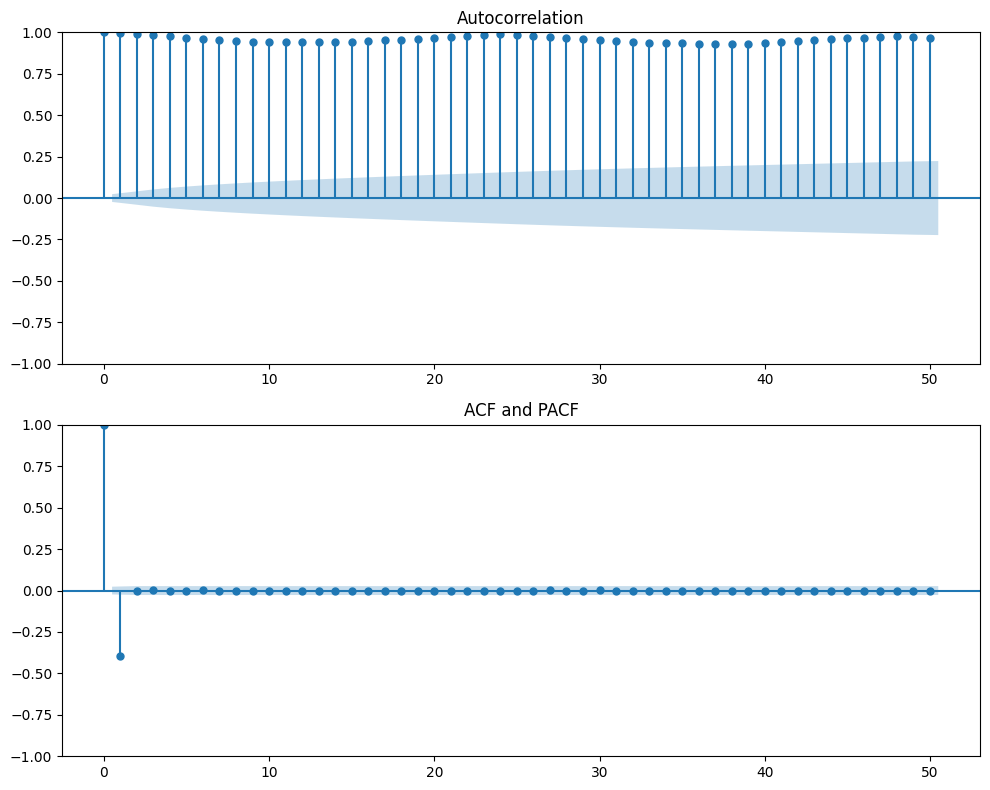

In [104]:
# Plot ACF and PACF

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(train["setpoint"], lags=50, ax=ax[0])
plot_acf(model_fit.resid, lags=50, ax=ax[1])
plt.title("ACF and PACF")
plt.tight_layout()
plt.show()

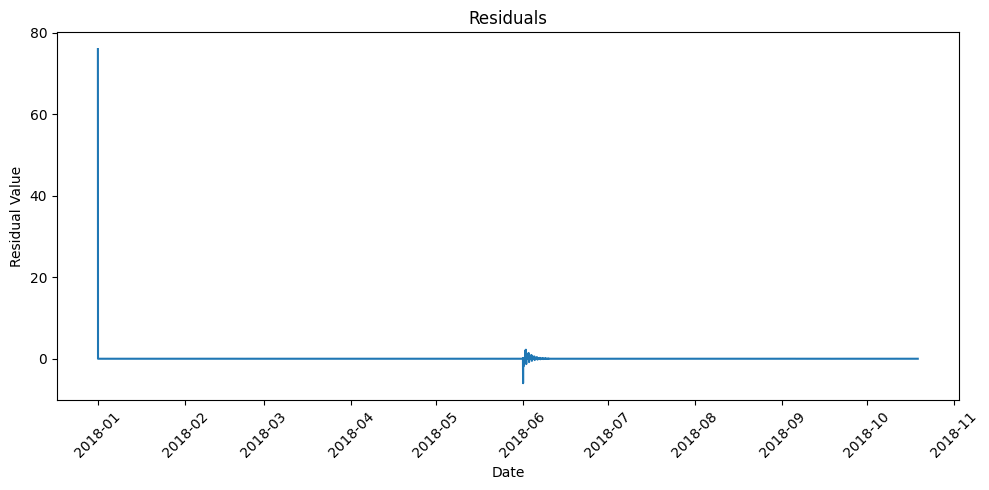

In [100]:
# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title("Residuals")
plt.xlabel("Date")
plt.ylabel("Residual Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()